In [1]:
building_id = 2
price = 100
iteration = 0
# we are ready to run!

In [2]:
# Parameters
building_id = 2
price = 200
iteration = 5


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_dual.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_dual_processed.xlsx".format(price)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep()

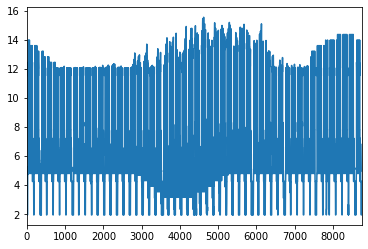

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m²
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.713136672973633 sec


0.0


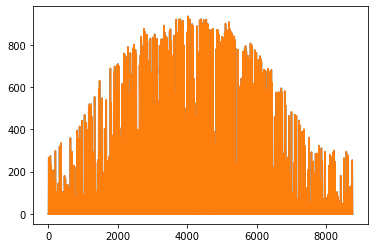

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 7882.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.1253 /kWh
Total Cost of the system: $ 7,882 per year


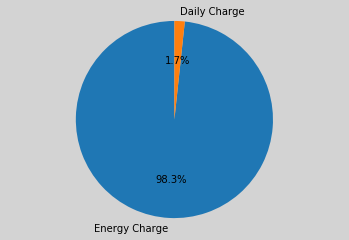

Total roof area of the  building: 599 m²
Total roof area used 0 m²
Percentage: 0.0%


In [16]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

61845.7

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr             0.0
Aug             0.0
Dec             0.0
Feb             0.0
Jan             0.0
Jul             0.0
Jun             0.0
Mar             0.0
May             0.0
Nov             0.0
Oct             0.0
Sep             0.0
monthly_export    0.0
dtype: float64
0.0
133.042


In [20]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             0
PV0                  0
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

0

In [23]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 185, 135, 41, 36, 21, 0.8999999999999999, 0.39999999999999997, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.528710126876831 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 239.505, 0.0]


ERROR:ga_logger:Cost: 6035.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0229 /kWh
Total Cost of the system: $ 6,036 per year


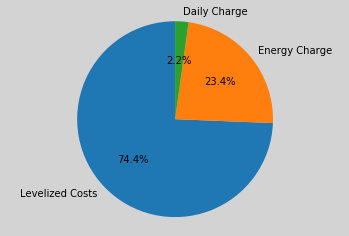

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 235, 170, 21, 26, 16, 0.5999999999999999, 0.39999999999999997, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [302.557, 0.0, 0.0]


ERROR:ga_logger:Cost: 5802.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,803 per year


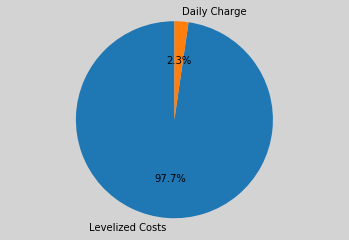

Total roof area of the  building: 599 m²
Total roof area used 504 m²
Percentage: 84.2%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 170, 125, 46, 26, 16, 0.7, 0.7999999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 16.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.5563013553619385 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 312.435, 0.0]


ERROR:ga_logger:Cost: 5988.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,988 per year


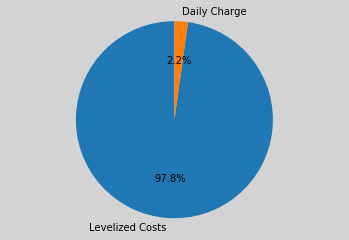

Total roof area of the  building: 599 m²
Total roof area used 391 m²
Percentage: 65.2%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (260, 160, 250, 26, 56, 21, 0.49999999999999994, 0.7499999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 26.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.249964475631714 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 348.072]


ERROR:ga_logger:Cost: 6655.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,656 per year


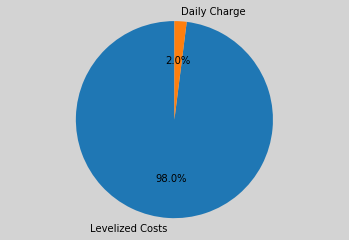

Total roof area of the  building: 599 m²
Total roof area used 464 m²
Percentage: 77.5%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205, 245, 105, 31, 21, 21, 0.35, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 31.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.832508563995361 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 329.319, 0.0]


ERROR:ga_logger:Cost: 6344.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0006 /kWh
Total Cost of the system: $ 6,344 per year


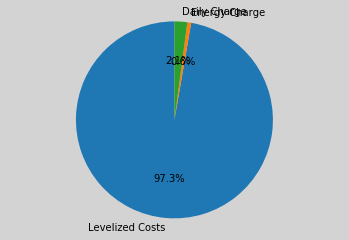

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 215, 185, 41, 36, 36, 0.35, 0.49999999999999994, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [140.706, 0.0, 167.233]


ERROR:ga_logger:Cost: 5903.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,904 per year


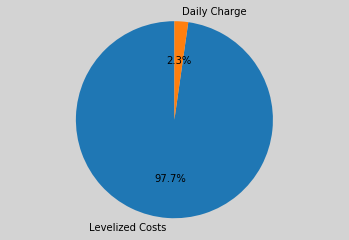

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 230, 155, 46, 21, 16, 0.49999999999999994, 0.39999999999999997, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 21.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.257123231887817 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.128]


ERROR:ga_logger:Cost: 5963.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,964 per year


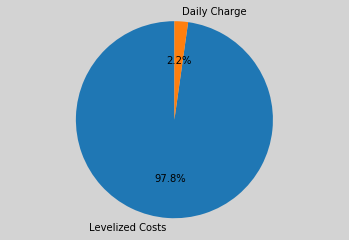

Total roof area of the  building: 599 m²
Total roof area used 444 m²
Percentage: 74.2%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 205, 100, 21, 16, 26, 0.7499999999999998, 0.35, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [185.011, 123.228, 0.0]


ERROR:ga_logger:Cost: 5909.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,909 per year


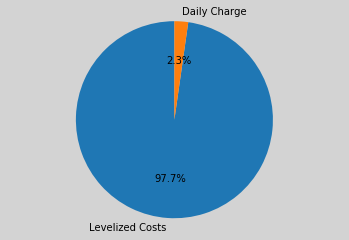

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 175, 235, 11, 11, 11, 0.35, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 11.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.911125898361206 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.506383895874023 sec


ERROR:ga_logger:Generated the panel irradiance in  17s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [135.565, 0.0, 190.289]


ERROR:ga_logger:Cost: 6239.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,240 per year


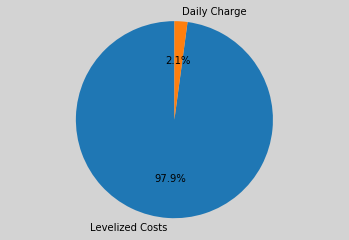

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 225, 145, 46, 56, 51, 0.39999999999999997, 0.35, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [239.505, 0.0, 0.0]


ERROR:ga_logger:Cost: 6191.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0254 /kWh
Total Cost of the system: $ 6,191 per year


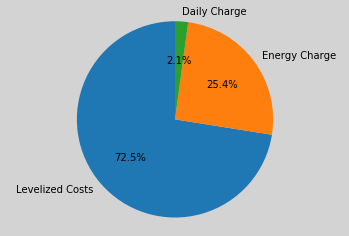

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 255, 185, 11, 36, 6, 0.6499999999999999, 0.5999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.935855388641357 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 6.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.533267021179199 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 320.423]


ERROR:ga_logger:Cost: 6137.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,138 per year


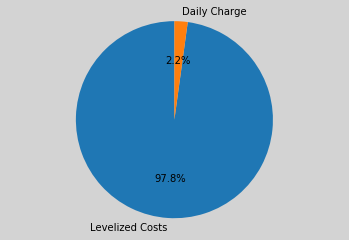

Total roof area of the  building: 599 m²
Total roof area used 583 m²
Percentage: 97.3%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 170, 150, 56, 46, 56, 0.5499999999999999, 0.49999999999999994, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.597055912017822 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.641209363937378 sec


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 5906.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0026 /kWh
Total Cost of the system: $ 5,907 per year


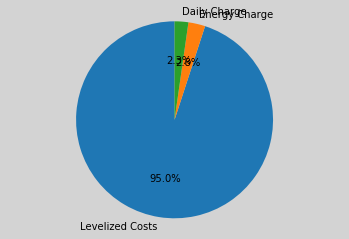

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 160, 235, 6, 46, 26, 0.3, 0.8499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.440622091293335 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [92.5275, 246.786, 0.0]


ERROR:ga_logger:Cost: 6491.79


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,492 per year


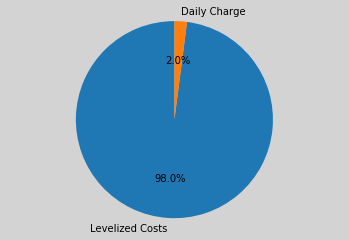

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 235, 210, 6, 41, 46, 0.25, 0.8499999999999999, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 46.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.11061692237854 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 149.69]


ERROR:ga_logger:Cost: 6898.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0640 /kWh
Total Cost of the system: $ 6,898 per year


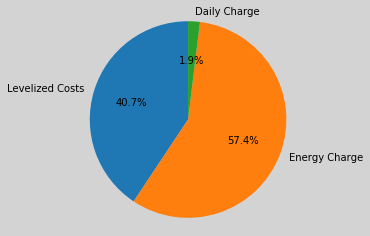

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 220, 170, 56, 26, 36, 0.5999999999999999, 0.35, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.814]


ERROR:ga_logger:Cost: 5714.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,714 per year


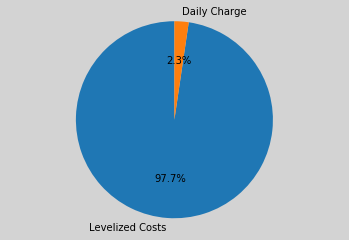

Total roof area of the  building: 599 m²
Total roof area used 596 m²
Percentage: 99.5%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95, 115, 105, 51, 26, 31, 0.7, 0.5999999999999999, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 51.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.696308851242065 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 317.121, 17.5569]


ERROR:ga_logger:Cost: 6404.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,405 per year


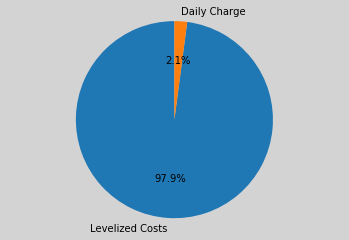

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170, 125, 260, 51, 31, 41, 0.5499999999999999, 0.8999999999999999, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [315.543, 0.0, 0.0]


ERROR:ga_logger:Cost: 6046.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,046 per year


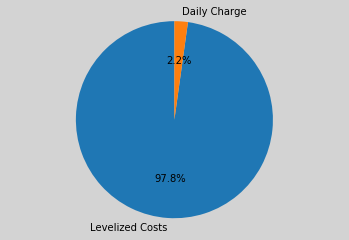

Total roof area of the  building: 599 m²
Total roof area used 574 m²
Percentage: 95.8%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105, 95, 240, 41, 36, 46, 0.44999999999999996, 0.6499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 36.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.381]


ERROR:ga_logger:Cost: 6940.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0194 /kWh
Total Cost of the system: $ 6,941 per year


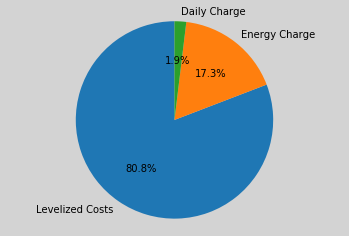

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 165, 250, 21, 41, 21, 0.5999999999999999, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.436981439590454 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 308.382, 0.0]


ERROR:ga_logger:Cost: 5912.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,912 per year


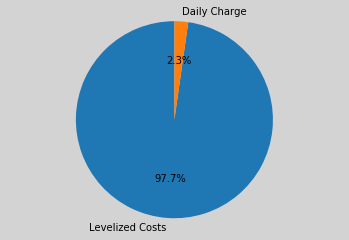

Total roof area of the  building: 599 m²
Total roof area used 514 m²
Percentage: 85.8%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 175, 225, 41, 26, 41, 0.7, 0.8999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.0633063316345215 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.535964488983154 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in  17s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 320.382, 0.0]


ERROR:ga_logger:Cost: 6137.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,137 per year


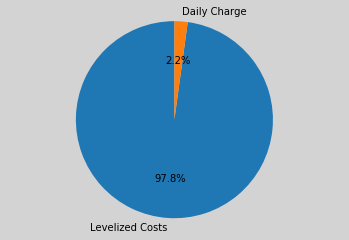

ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 599 m²
Total roof area used 356 m²
Percentage: 59.5%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 265, 130, 31, 21, 11, 0.39999999999999997, 0.44999999999999996, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [177.689, 0.0, 139.086]


ERROR:ga_logger:Cost: 6069.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,069 per year


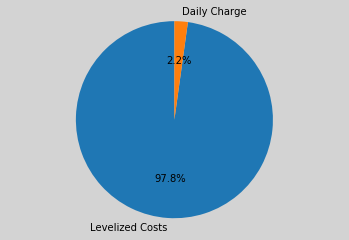

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 250, 265, 6, 31, 21, 0.7499999999999998, 0.7, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [321.942, 0.0, 0.0]


ERROR:ga_logger:Cost: 6166.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,166 per year


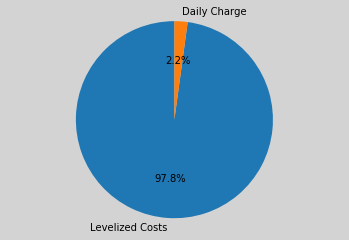

Total roof area of the  building: 599 m²
Total roof area used 429 m²
Percentage: 71.7%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 185, 245, 26, 41, 21, 0.35, 0.6499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.299984455108643 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 306.267, 0.0]


ERROR:ga_logger:Cost: 5872.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,873 per year


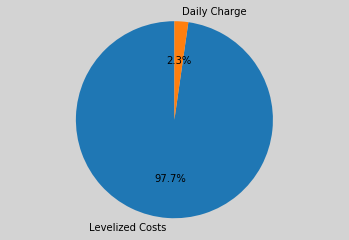

Total roof area of the  building: 599 m²
Total roof area used 471 m²
Percentage: 78.7%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 185, 100, 31, 56, 31, 0.49999999999999994, 0.25, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.205480337142944 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [299.381, 0.0, 0.0]


ERROR:ga_logger:Cost: 6158.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0067 /kWh
Total Cost of the system: $ 6,158 per year


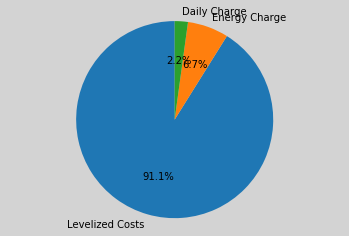

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 105, 215, 56, 56, 51, 0.5499999999999999, 0.44999999999999996, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 51.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.450049877166748 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 338.938]


ERROR:ga_logger:Cost: 6484.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,485 per year


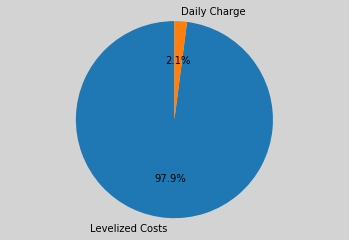

Total roof area of the  building: 599 m²
Total roof area used 565 m²
Percentage: 94.3%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 250, 205, 36, 16, 56, 0.7, 0.7, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 36.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.445115804672241 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 16.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.71740984916687 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in  16s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [320.335, 0.0, 0.0]


ERROR:ga_logger:Cost: 6136.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,136 per year


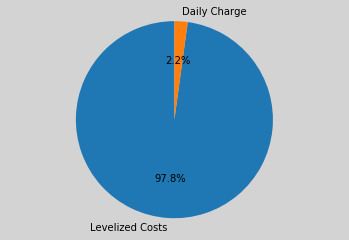

Total roof area of the  building: 599 m²
Total roof area used 458 m²
Percentage: 76.4%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 120, 170, 46, 31, 41, 0.49999999999999994, 0.5499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 239.505]


ERROR:ga_logger:Cost: 6115.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0242 /kWh
Total Cost of the system: $ 6,115 per year


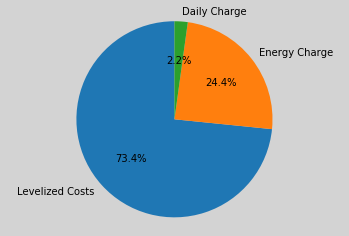

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 245, 190, 36, 1, 51, 0.5999999999999999, 0.3, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 36.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.914853572845459 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.892613410949707 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 51.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [287.338, 0.0, 23.9729]


ERROR:ga_logger:Cost: 5967.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,967 per year


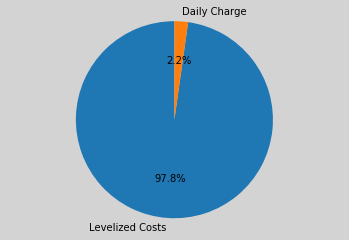

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 230, 120, 51, 16, 21, 0.25, 0.35, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 73.9826, 251.799]


ERROR:ga_logger:Cost: 6238.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,238 per year


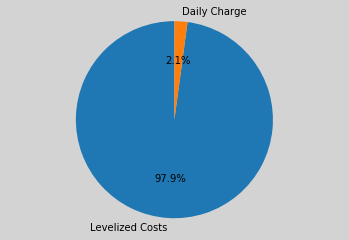

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 115, 205, 36, 11, 16, 0.8999999999999999, 0.8999999999999999, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 36.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.811505079269409 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 251.524, 79.8228]


ERROR:ga_logger:Cost: 6342.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,342 per year


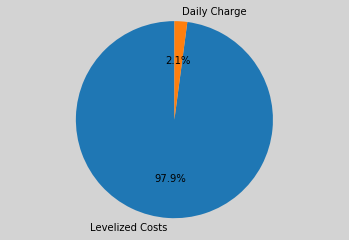

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 195, 225, 6, 36, 41, 0.7999999999999998, 0.49999999999999994, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 298.906, 0.0]


ERROR:ga_logger:Cost: 5734.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,735 per year


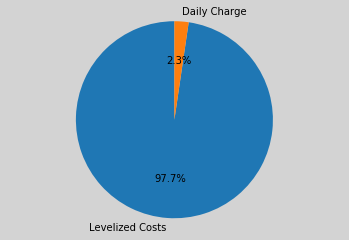

Total roof area of the  building: 599 m²
Total roof area used 598 m²
Percentage: 99.8%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 195, 150, 51, 6, 16, 0.25, 0.3, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.381]


ERROR:ga_logger:Cost: 5942.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0032 /kWh
Total Cost of the system: $ 5,943 per year


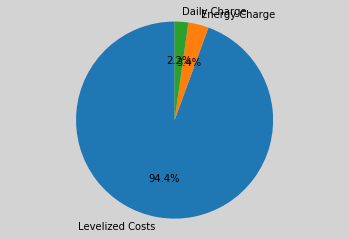

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 190, 95, 31, 36, 16, 0.5999999999999999, 0.2, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.052850008010864 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [268.415, 30.2808, 0.0]


ERROR:ga_logger:Cost: 5730.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,731 per year


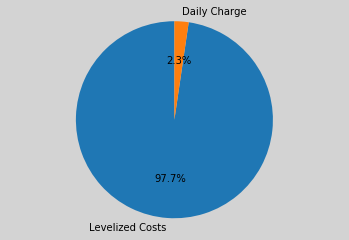

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 230, 90, 16, 41, 11, 0.2, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.38515567779541 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 11.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.588768243789673 sec


ERROR:ga_logger:Generated the panel irradiance in  16s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [40.3458, 0.0, 297.774]


ERROR:ga_logger:Cost: 6469.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,469 per year


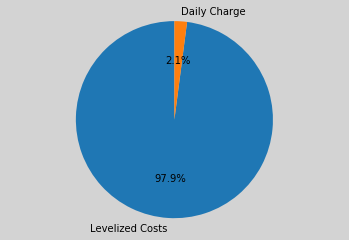

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 115, 115, 21, 1, 16, 0.2, 0.6499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.648283243179321 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [42.9454, 0.0, 288.026]


ERROR:ga_logger:Cost: 6335.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,335 per year


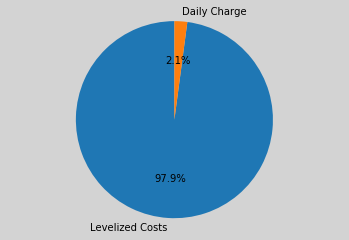

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 125, 245, 31, 31, 11, 0.6499999999999999, 0.5499999999999999, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 31.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.722464323043823 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 325.974, 0.0]


ERROR:ga_logger:Cost: 6241.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ -0.0000 /kWh
Total Cost of the system: $ 6,242 per year


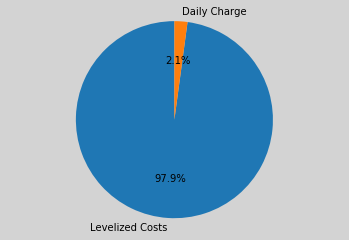

Total roof area of the  building: 599 m²
Total roof area used 593 m²
Percentage: 99.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 100, 185, 16, 11, 51, 0.25, 0.3, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 149.69]


ERROR:ga_logger:Cost: 6827.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0629 /kWh
Total Cost of the system: $ 6,827 per year


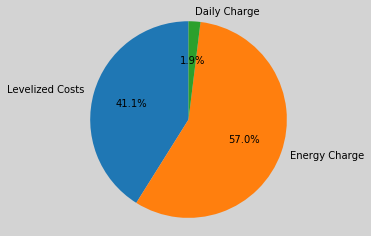

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 210, 145, 16, 41, 36, 0.35, 0.2, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 16.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.532301902770996 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 41.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.927428245544434 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 179.629]


ERROR:ga_logger:Cost: 6613.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0504 /kWh
Total Cost of the system: $ 6,613 per year


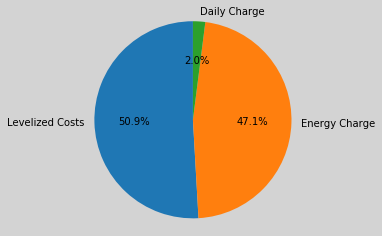

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (235, 135, 180, 46, 6, 31, 0.39999999999999997, 0.7999999999999998, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 46.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.278006792068481 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.121893644332886 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in  18s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 179.851, 130.882]


ERROR:ga_logger:Cost: 5956.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,956 per year


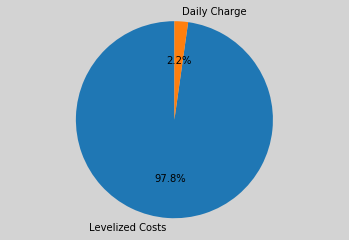

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 160, 210, 26, 21, 16, 0.7, 0.39999999999999997, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 239.505, 0.0]


ERROR:ga_logger:Cost: 6163.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0249 /kWh
Total Cost of the system: $ 6,163 per year


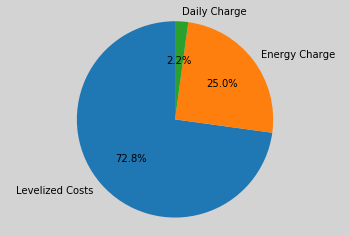

ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 95, 140, 36, 11, 41, 0.6499999999999999, 0.8999999999999999, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.833177804946899 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [315.863, 0.0, 22.5636]


ERROR:ga_logger:Cost: 6475.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,475 per year


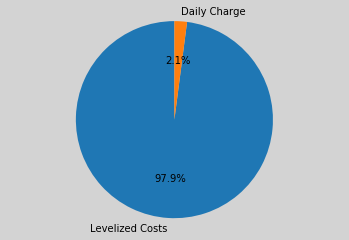

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 195, 150, 36, 21, 21, 0.49999999999999994, 0.2, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [298.588, 0.317243, 0.0]


ERROR:ga_logger:Cost: 5734.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,735 per year


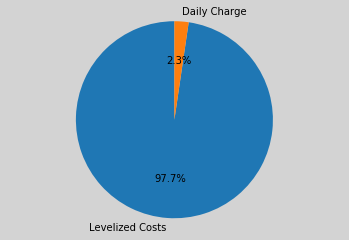

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 260, 145, 56, 31, 46, 0.5999999999999999, 0.5999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 31.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.849823236465454 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [136.729, 0.0, 185.44]


ERROR:ga_logger:Cost: 6170.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,170 per year


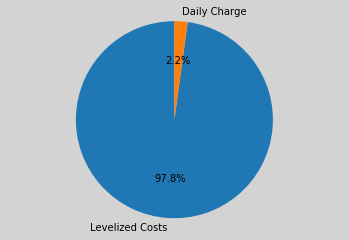

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 170, 100, 16, 21, 26, 0.5499999999999999, 0.7999999999999998, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.58000373840332 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 311.939, 0.0]


ERROR:ga_logger:Cost: 5978.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,979 per year


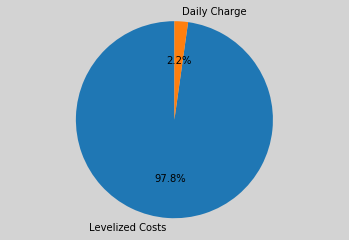

Total roof area of the  building: 599 m²
Total roof area used 390 m²
Percentage: 65.1%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 100, 150, 11, 1, 11, 0.35, 0.8499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 1.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.869258165359497 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [127.218, 0.0, 188.225]


ERROR:ga_logger:Cost: 6044.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,044 per year


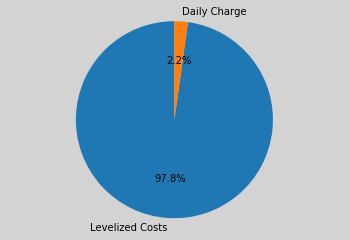

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 260, 135, 56, 1, 31, 0.5499999999999999, 0.44999999999999996, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 1.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.872914791107178 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 31.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.856309652328491 sec


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 239.505]


ERROR:ga_logger:Cost: 6360.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0281 /kWh
Total Cost of the system: $ 6,361 per year


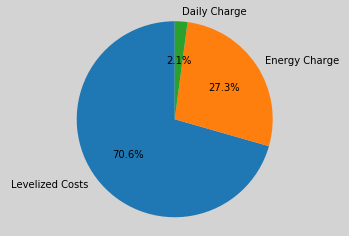

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 265, 95, 51, 41, 46, 0.2, 0.7, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 51.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.375954627990723 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [119.752, 0.0, 0.0]


ERROR:ga_logger:Cost: 7293.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0795 /kWh
Total Cost of the system: $ 7,294 per year


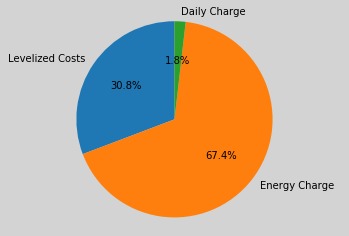

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 235, 230, 41, 26, 41, 0.6499999999999999, 0.6499999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [321.735, 0.0, 0.0]


ERROR:ga_logger:Cost: 6162.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,162 per year


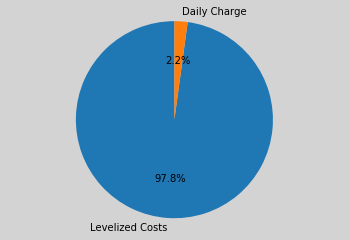

Total roof area of the  building: 599 m²
Total roof area used 495 m²
Percentage: 82.7%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 200, 95, 26, 16, 46, 0.8999999999999999, 0.5999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.726191997528076 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.8941709995269775 sec


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 307.481, 0.0]


ERROR:ga_logger:Cost: 5895.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,895 per year


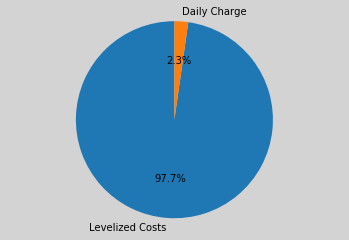

Total roof area of the  building: 599 m²
Total roof area used 512 m²
Percentage: 85.6%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 205, 200, 41, 21, 56, 0.7499999999999998, 0.7999999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 317.235, 0.0]


ERROR:ga_logger:Cost: 6078.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,078 per year


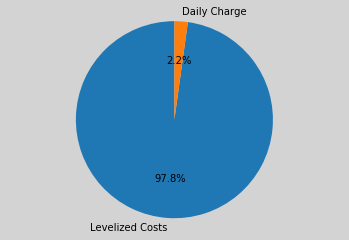

Total roof area of the  building: 599 m²
Total roof area used 397 m²
Percentage: 66.2%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 130, 95, 1, 36, 41, 0.44999999999999996, 0.2, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 41.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.118067741394043 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [269.443, 0.0, 0.0]


ERROR:ga_logger:Cost: 6696.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0245 /kWh
Total Cost of the system: $ 6,696 per year


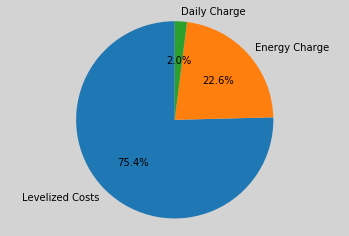

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95, 195, 145, 51, 16, 46, 0.8999999999999999, 0.35, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 14.581036806106567 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in  15s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 10.5975, 312.666]


ERROR:ga_logger:Cost: 6191.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,191 per year


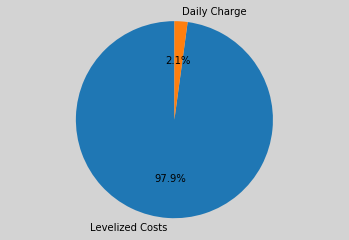

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 135, 220, 6, 41, 6, 0.8499999999999999, 0.5499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 6.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.2002341747283936 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [63.1513, 0.0, 262.233]


ERROR:ga_logger:Cost: 6230.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,231 per year


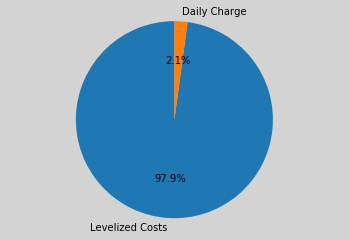

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 265, 90, 46, 51, 11, 0.49999999999999994, 0.5999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 51.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.61794662475586 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [299.381, 0.0, 0.0]


ERROR:ga_logger:Cost: 5999.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0041 /kWh
Total Cost of the system: $ 6,000 per year


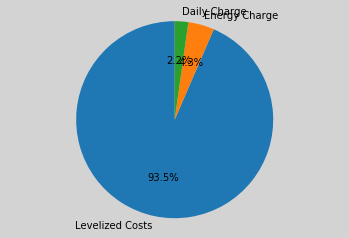

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 140, 180, 1, 51, 16, 0.7, 0.5999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 305.975]


ERROR:ga_logger:Cost: 5867.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,867 per year


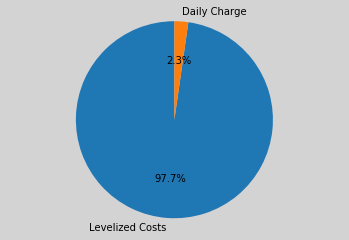

Total roof area of the  building: 599 m²
Total roof area used 471 m²
Percentage: 78.6%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 180, 170, 11, 11, 16, 0.44999999999999996, 0.8999999999999999, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.125763654708862 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 168.039, 144.218]


ERROR:ga_logger:Cost: 5984.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,985 per year


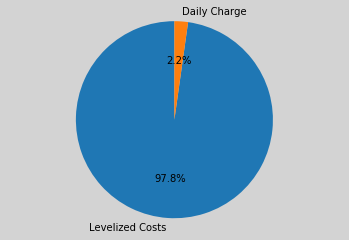

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 110, 170, 46, 31, 21, 0.7999999999999998, 0.2, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.702999114990234 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 316.072]


ERROR:ga_logger:Cost: 6056.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,056 per year


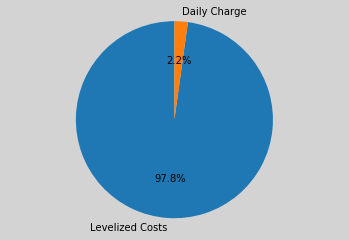

Total roof area of the  building: 599 m²
Total roof area used 372 m²
Percentage: 62.1%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120, 215, 195, 36, 16, 21, 0.49999999999999994, 0.8999999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.443894624710083 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 312.817]


ERROR:ga_logger:Cost: 5995.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,995 per year


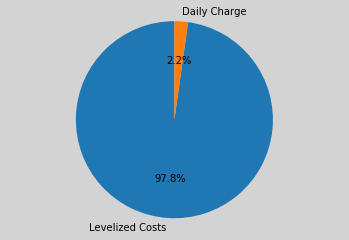

Total roof area of the  building: 599 m²
Total roof area used 391 m²
Percentage: 65.3%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 260, 130, 26, 56, 21, 0.8999999999999999, 0.35, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 327.626]


ERROR:ga_logger:Cost: 6272.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,273 per year


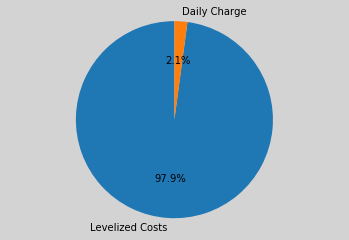

Total roof area of the  building: 599 m²
Total roof area used 437 m²
Percentage: 73.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 260, 265, 11, 11, 51, 0.5499999999999999, 0.39999999999999997, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [316.63, 0.0, 0.0]


ERROR:ga_logger:Cost: 6066.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,067 per year


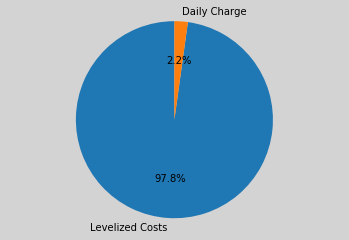

ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 599 m²
Total roof area used 576 m²
Percentage: 96.1%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 110, 125, 46, 11, 51, 0.8999999999999999, 0.2, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 11.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.403984785079956 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 51.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.677899122238159 sec


ERROR:ga_logger:Generated the panel irradiance in  16s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 209.567]


ERROR:ga_logger:Cost: 7007.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0477 /kWh
Total Cost of the system: $ 7,007 per year


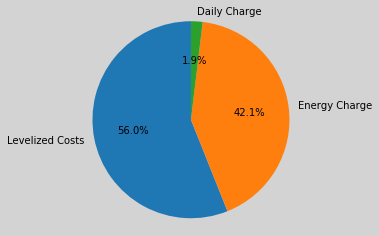

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120, 155, 230, 6, 41, 31, 0.5499999999999999, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.075320482254028 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 5934.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0031 /kWh
Total Cost of the system: $ 5,935 per year


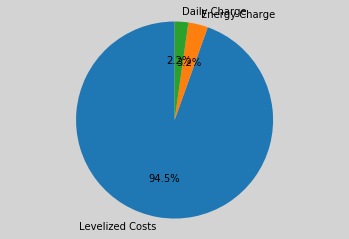

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245, 145, 95, 6, 11, 11, 0.35, 0.35, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 122.726, 210.9]


ERROR:ga_logger:Cost: 6385.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,385 per year


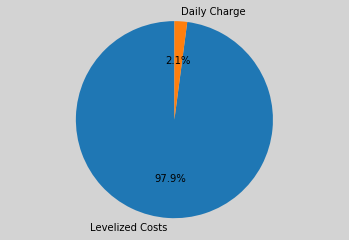

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 195, 190, 56, 56, 21, 0.49999999999999994, 0.3, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 106.098, 208.336]


ERROR:ga_logger:Cost: 6025.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,026 per year


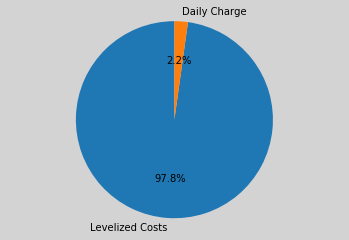

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 265, 230, 31, 56, 51, 0.7, 0.39999999999999997, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [330.115, 0.0, 0.0]


ERROR:ga_logger:Cost: 6319.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ -0.0000 /kWh
Total Cost of the system: $ 6,319 per year


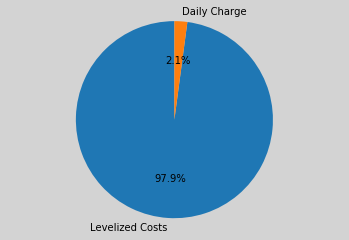

Total roof area of the  building: 599 m²
Total roof area used 472 m²
Percentage: 78.8%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170, 105, 140, 26, 56, 41, 0.2, 0.2, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 26.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.55286717414856 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [17.5284, 0.0, 306.672]


ERROR:ga_logger:Cost: 6208.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,209 per year


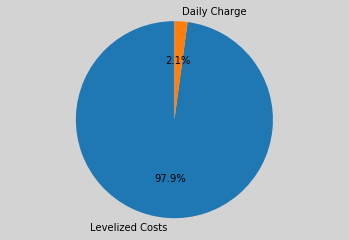

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 180, 140, 41, 16, 36, 0.7499999999999998, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.094418287277222 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 304.827, 0.0]


ERROR:ga_logger:Cost: 5845.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,846 per year


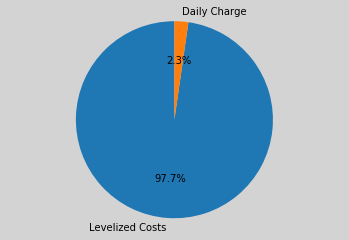

Total roof area of the  building: 599 m²
Total roof area used 508 m²
Percentage: 84.8%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 210, 120, 46, 16, 1, 0.44999999999999996, 0.8999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 1.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.995697975158691 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 327.827, 0.0]


ERROR:ga_logger:Cost: 6276.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,277 per year


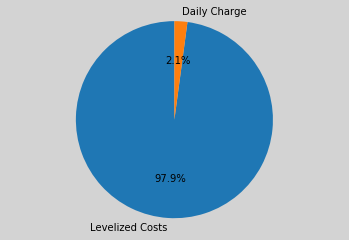

Total roof area of the  building: 599 m²
Total roof area used 364 m²
Percentage: 60.8%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 200, 140, 41, 16, 36, 0.7999999999999998, 0.3, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.941265821456909 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [221.493, 0.0, 96.5687]


ERROR:ga_logger:Cost: 6093.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,094 per year


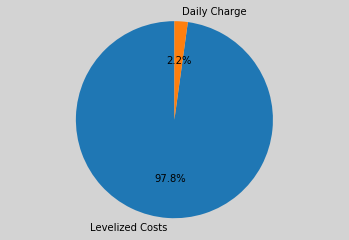

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 115, 245, 41, 26, 21, 0.49999999999999994, 0.7999999999999998, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 26.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.169207811355591 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 338.893]


ERROR:ga_logger:Cost: 6483.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,484 per year


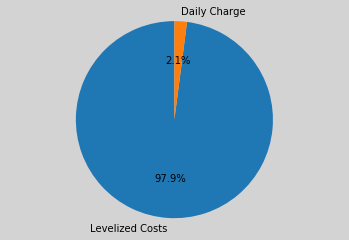

Total roof area of the  building: 599 m²
Total roof area used 484 m²
Percentage: 80.9%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 175, 210, 16, 41, 11, 0.7499999999999998, 0.35, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 68.0179, 242.655]


ERROR:ga_logger:Cost: 5955.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,955 per year


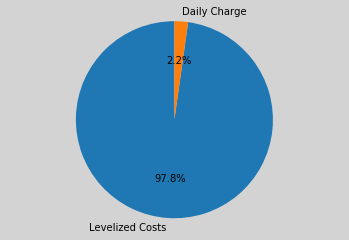

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120, 110, 155, 56, 16, 56, 0.7499999999999998, 0.49999999999999994, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 6405.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0107 /kWh
Total Cost of the system: $ 6,405 per year


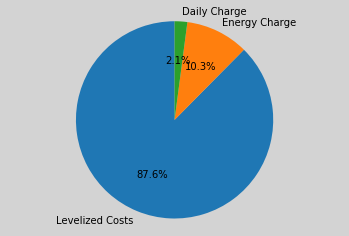

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 140, 180, 6, 31, 46, 0.44999999999999996, 0.7999999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.281252145767212 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.525]


ERROR:ga_logger:Cost: 5877.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,877 per year


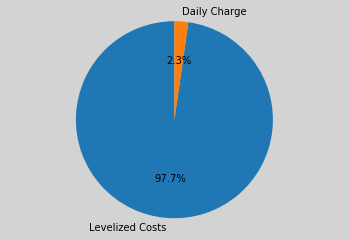

Total roof area of the  building: 599 m²
Total roof area used 557 m²
Percentage: 93.1%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 215, 260, 56, 16, 16, 0.25, 0.2, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.689061641693115 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.381]


ERROR:ga_logger:Cost: 6655.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0147 /kWh
Total Cost of the system: $ 6,655 per year


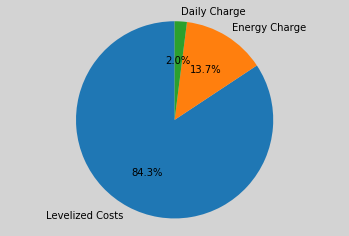

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 105, 110, 26, 26, 21, 0.8499999999999999, 0.44999999999999996, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.651470422744751 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.872030258178711 sec


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [315.475, 0.0, 0.0]


ERROR:ga_logger:Cost: 6045.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,045 per year


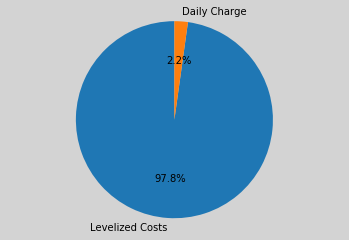

Total roof area of the  building: 599 m²
Total roof area used 371 m²
Percentage: 62.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 135, 95, 36, 41, 56, 0.25, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.8936240673065186 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 179.629, 0.0]


ERROR:ga_logger:Cost: 6766.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0528 /kWh
Total Cost of the system: $ 6,766 per year


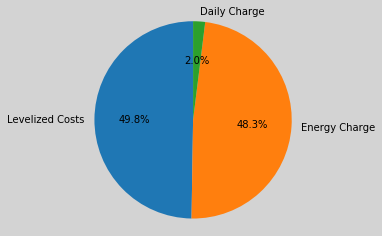

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 135, 220, 1, 36, 56, 0.6499999999999999, 0.25, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.071179151535034 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.126556396484375 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.343862295150757 sec


ERROR:ga_logger:Generated the panel irradiance in  19s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [296.559, 35.6294, 0.0]


ERROR:ga_logger:Cost: 6358.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,358 per year


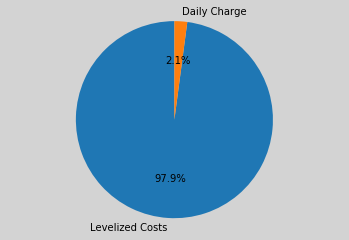

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 260, 260, 51, 11, 36, 0.8999999999999999, 0.5999999999999999, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 337.323, 0.0]


ERROR:ga_logger:Cost: 6454.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,454 per year


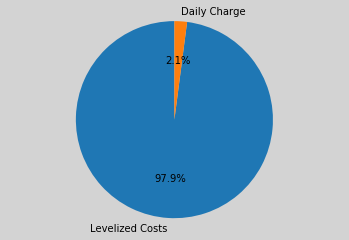

Total roof area of the  building: 599 m²
Total roof area used 562 m²
Percentage: 93.9%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 105, 100, 16, 56, 56, 0.2, 0.35, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.3853209018707275 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 56.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.51980209350586 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in  15s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [119.752, 0.0, 0.0]


ERROR:ga_logger:Cost: 7058.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0757 /kWh
Total Cost of the system: $ 7,059 per year


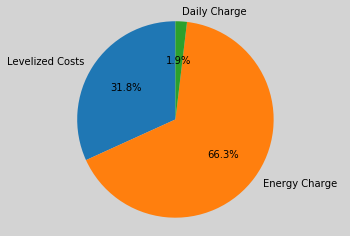

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 255, 165, 41, 41, 36, 0.3, 0.8499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [56.0383, 0.0, 247.18]


ERROR:ga_logger:Cost: 5815.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,815 per year


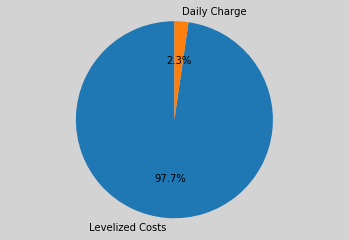

ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 200, 90, 1, 1, 36, 0.7499999999999998, 0.2, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 1.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.095263481140137 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 36.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.63990330696106 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [294.308, 41.2701, 0.0]


ERROR:ga_logger:Cost: 6421.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,422 per year


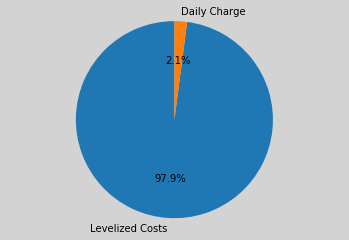

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 225, 210, 46, 51, 41, 0.44999999999999996, 0.6499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 46.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.794043302536011 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [217.661, 0.0, 97.8099]


ERROR:ga_logger:Cost: 6044.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,045 per year


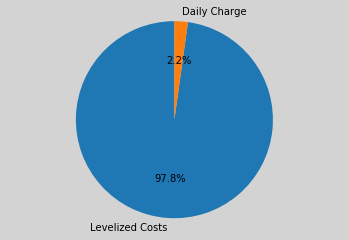

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105, 265, 265, 31, 56, 31, 0.5999999999999999, 0.44999999999999996, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 31.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 12.040553331375122 sec


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [355.411, 0.0, 0.0]


ERROR:ga_logger:Cost: 6793.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,793 per year


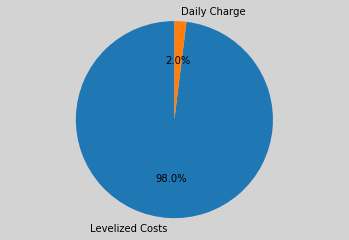

Total roof area of the  building: 599 m²
Total roof area used 592 m²
Percentage: 98.9%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 95, 155, 1, 11, 31, 0.35, 0.44999999999999996, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.185]


ERROR:ga_logger:Cost: 5870.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,871 per year


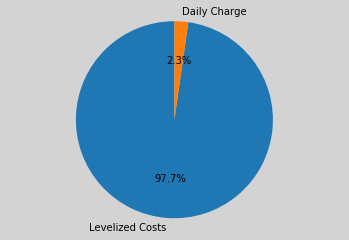

Total roof area of the  building: 599 m²
Total roof area used 510 m²
Percentage: 85.2%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 130, 215, 21, 6, 16, 0.8499999999999999, 0.2, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.266956329345703 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 6.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.884228229522705 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in  15s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.92]


ERROR:ga_logger:Cost: 5978.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,978 per year


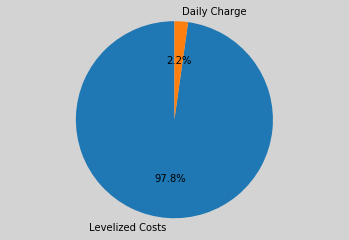

Total roof area of the  building: 599 m²
Total roof area used 567 m²
Percentage: 94.7%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 95, 180, 11, 26, 41, 0.35, 0.3, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.381]


ERROR:ga_logger:Cost: 5745.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,745 per year


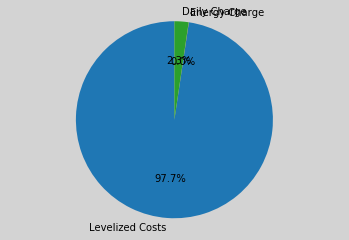

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 205, 95, 1, 41, 31, 0.3, 0.25, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.546011924743652 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.7462451457977295 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 31.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.673342704772949 sec


ERROR:ga_logger:Generated the panel irradiance in  18s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 149.69, 0.0]


ERROR:ga_logger:Cost: 6811.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0626 /kWh
Total Cost of the system: $ 6,812 per year


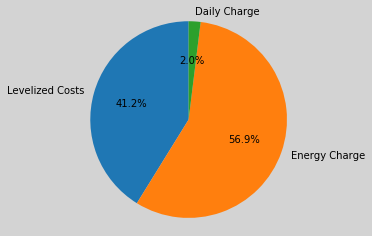

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 220, 165, 16, 1, 11, 0.8999999999999999, 0.8499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.14337420463562 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 316.508]


ERROR:ga_logger:Cost: 6064.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,064 per year


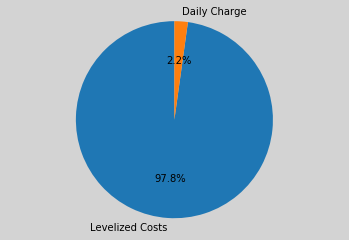

Total roof area of the  building: 599 m²
Total roof area used 396 m²
Percentage: 66.1%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (235, 90, 245, 16, 11, 1, 0.8999999999999999, 0.7, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 11.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.7359325885772705 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.2002599239349365 sec


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 309.859, 31.2211]


ERROR:ga_logger:Cost: 6524.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,525 per year


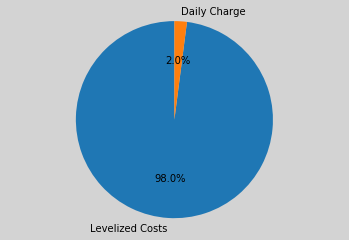

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 195, 120, 26, 21, 46, 0.8499999999999999, 0.35, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [169.085, 139.943, 0.0]


ERROR:ga_logger:Cost: 5924.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,924 per year


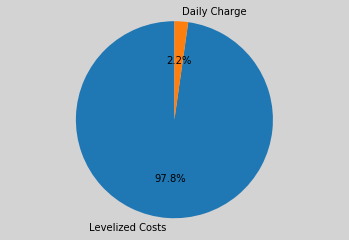

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 195, 110, 36, 41, 36, 0.5499999999999999, 0.7999999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.021734714508057 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [303.68, 0.0, 0.0]


ERROR:ga_logger:Cost: 5824.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,824 per year


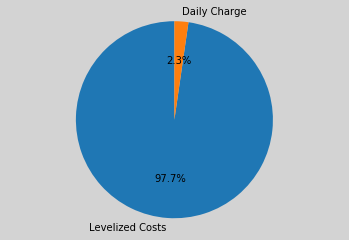

Total roof area of the  building: 599 m²
Total roof area used 552 m²
Percentage: 92.2%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 200, 220, 11, 26, 36, 0.5999999999999999, 0.2, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [286.684, 24.1909, 0.0]


ERROR:ga_logger:Cost: 5958.86


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,959 per year


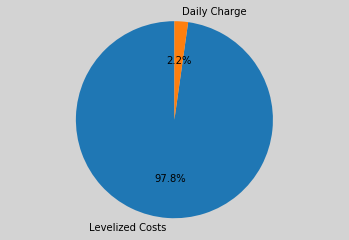

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 245, 230, 41, 16, 21, 0.6499999999999999, 0.2, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 11.801753759384155 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 269.443]


ERROR:ga_logger:Cost: 6331.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0186 /kWh
Total Cost of the system: $ 6,332 per year


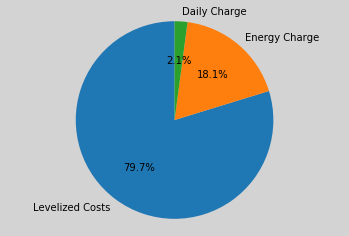

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 225, 200, 16, 11, 41, 0.3, 0.35, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [65.8672, 0.0, 246.483]


ERROR:ga_logger:Cost: 5986.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,986 per year


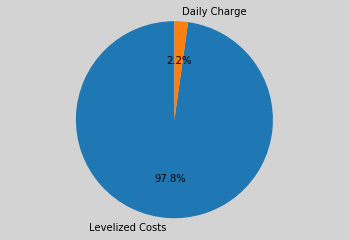

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 255, 110, 46, 21, 26, 0.49999999999999994, 0.8999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [299.381, 0.0, 0.0]


ERROR:ga_logger:Cost: 6241.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0081 /kWh
Total Cost of the system: $ 6,241 per year


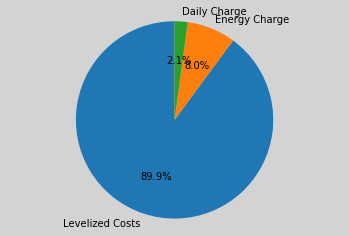

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 125, 215, 1, 1, 31, 0.3, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 325.346]


ERROR:ga_logger:Cost: 6230.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,230 per year


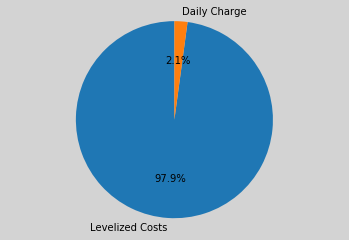

Total roof area of the  building: 599 m²
Total roof area used 434 m²
Percentage: 72.4%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205, 110, 220, 41, 6, 31, 0.7999999999999998, 0.3, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [109.643, 0.0, 207.769]


ERROR:ga_logger:Cost: 6081.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,081 per year


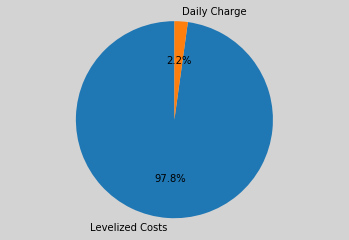

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 235, 180, 6, 51, 11, 0.5999999999999999, 0.7999999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 6.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.009106636047363 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.23920750617981 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in  15s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.381]


ERROR:ga_logger:Cost: 6019.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0045 /kWh
Total Cost of the system: $ 6,019 per year


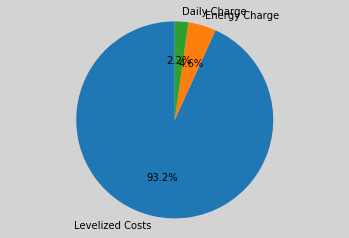

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 170, 190, 46, 41, 46, 0.44999999999999996, 0.8499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.129226922988892 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.368814706802368 sec


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [203.213, 0.0, 110.384]


ERROR:ga_logger:Cost: 6009.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 6,010 per year


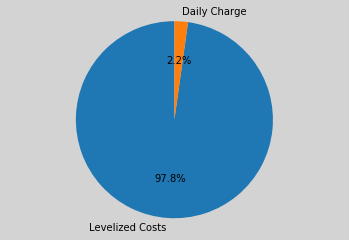

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 150, 180, 26, 36, 51, 0.7, 0.39999999999999997, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.064683198928833 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 239.505, 0.0]


ERROR:ga_logger:Cost: 6205.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0256 /kWh
Total Cost of the system: $ 6,205 per year


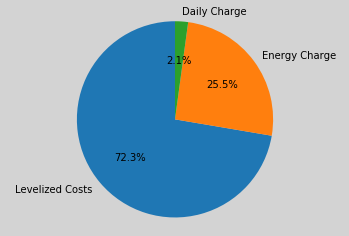

ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
20
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      115
azi1      220
azi2      170
tilt0      56
tilt1      26
tilt2      36
gcr0      0.6
gcr1     0.35
gcr2      0.5
Name: 0, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.814]


ERROR:ga_logger:Cost: 5714.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,714 per year


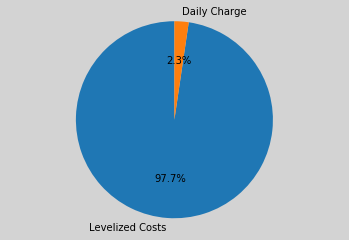

Total roof area of the  building: 599 m²
Total roof area used 596 m²
Percentage: 99.5%
[[115, 220, 170, 56, 26, 36, 0.5999999999999999, 0.35, 0.4999999999999999, 5714.1, 297.814, 0.0, 0.0, 297.814, 1, 'red', {'Levelized Costs': 5581.047, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60175510006, 61845.7, 595.629]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      175
azi1      190
azi2       95
tilt0      31
tilt1      36
tilt2      16
gcr0      0.6
gcr1      0.2
gcr2     0.85
Name: 1, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [268.415, 30.2808, 0.0]


ERROR:ga_logger:Cost: 5730.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,731 per year


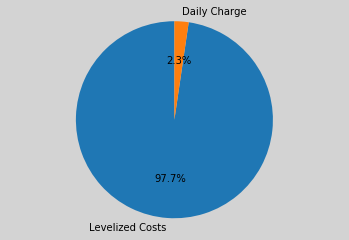

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[175, 190, 95, 31, 36, 16, 0.5999999999999999, 0.2, 0.8499999999999999, 5730.61, 298.6958, 268.415, 30.2808, 0.0, 1, 'blue', {'Levelized Costs': 5597.5509999999995, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60198209514, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0     195
azi1     195
azi2     150
tilt0     36
tilt1     21
tilt2     21
gcr0     0.5
gcr1     0.2
gcr2     0.9
Name: 2, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [298.588, 0.317243, 0.0]


ERROR:ga_logger:Cost: 5734.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,735 per year


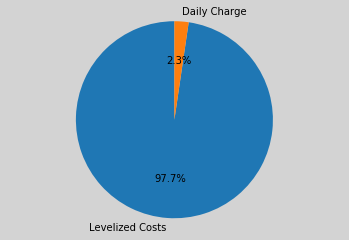

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[195, 195, 150, 36, 21, 21, 0.4999999999999999, 0.2, 0.8999999999999999, 5734.54, 298.90524300000004, 298.588, 0.317243, 0.0, 1, 'blue', {'Levelized Costs': 5601.48, 'Energy Charge': 0.01799999999997226, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602673612106, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0     165
azi1     195
azi2     225
tilt0      6
tilt1     36
tilt2     41
gcr0     0.8
gcr1     0.5
gcr2     0.5
Name: 3, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 298.906, 0.0]


ERROR:ga_logger:Cost: 5734.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,735 per year


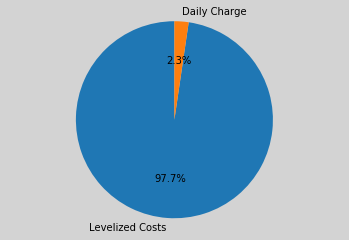

Total roof area of the  building: 599 m²
Total roof area used 598 m²
Percentage: 99.8%
[[165, 195, 225, 6, 36, 41, 0.7999999999999998, 0.4999999999999999, 0.4999999999999999, 5734.56, 298.906, 0.0, 298.906, 0.0, 1, 'blue', {'Levelized Costs': 5601.507, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60221155442, 61845.7, 597.812]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      150
azi1       95
azi2      180
tilt0      11
tilt1      26
tilt2      41
gcr0     0.35
gcr1      0.3
gcr2      0.5
Name: 4, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.381]


ERROR:ga_logger:Cost: 5745.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,745 per year


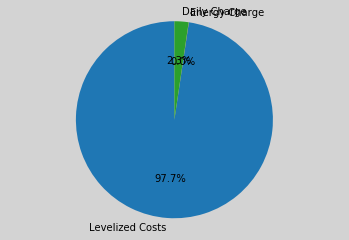

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[150, 95, 180, 11, 26, 41, 0.35, 0.3, 0.4999999999999999, 5745.02, 299.381, 0.0, 0.0, 299.381, 1, 'blue', {'Levelized Costs': 5610.398, 'Energy Charge': 1.5800000000002115, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61833.08264560029, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0     165
azi1     235
azi2     170
tilt0     21
tilt1     26
tilt2     16
gcr0     0.6
gcr1     0.4
gcr2     0.8
Name: 5, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [302.557, 0.0, 0.0]


ERROR:ga_logger:Cost: 5802.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,803 per year


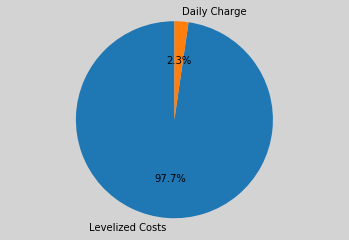

Total roof area of the  building: 599 m²
Total roof area used 504 m²
Percentage: 84.2%
[[165, 235, 170, 21, 26, 16, 0.5999999999999999, 0.4, 0.7999999999999998, 5802.97, 302.557, 302.557, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 5669.916, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60201010008, 61845.7, 504.261]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      200
azi1      255
azi2      165
tilt0      41
tilt1      41
tilt2      36
gcr0      0.3
gcr1     0.85
gcr2      0.6
Name: 6, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [56.0383, 0.0, 247.18]


ERROR:ga_logger:Cost: 5815.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,815 per year


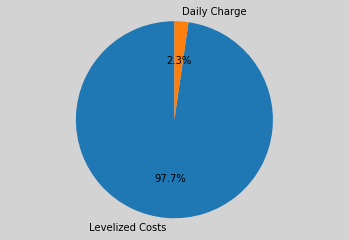

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[200, 255, 165, 41, 41, 36, 0.3, 0.8499999999999999, 0.5999999999999999, 5815.37, 303.2183, 56.0383, 0.0, 247.18, 1, 'blue', {'Levelized Costs': 5682.308999999999, 'Energy Charge': 0.019000000000005457, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601486638014, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      200
azi1      195
azi2      110
tilt0      36
tilt1      41
tilt2      36
gcr0     0.55
gcr1      0.8
gcr2      0.5
Name: 7, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [303.68, 0.0, 0.0]


ERROR:ga_logger:Cost: 5824.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,824 per year


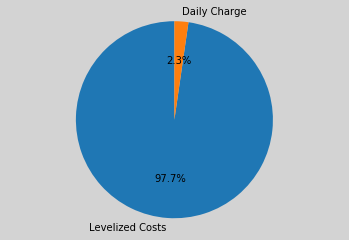

Total roof area of the  building: 599 m²
Total roof area used 552 m²
Percentage: 92.2%
[[200, 195, 110, 36, 41, 36, 0.5499999999999999, 0.7999999999999998, 0.4999999999999999, 5824.01, 303.68, 303.68, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 5690.958, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59908479387, 61845.7, 552.145]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      255
azi1      180
azi2      140
tilt0      41
tilt1      16
tilt2      36
gcr0     0.75
gcr1      0.6
gcr2      0.9
Name: 8, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 304.827, 0.0]


ERROR:ga_logger:Cost: 5845.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,846 per year


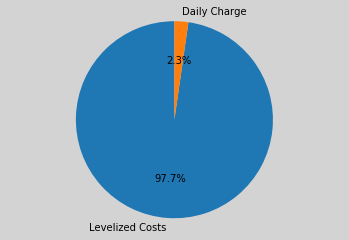

Total roof area of the  building: 599 m²
Total roof area used 508 m²
Percentage: 84.8%
[[255, 180, 140, 41, 16, 36, 0.7499999999999998, 0.5999999999999999, 0.8999999999999999, 5845.51, 304.827, 0.0, 304.827, 0.0, 1, 'blue', {'Levelized Costs': 5712.464999999999, 'Energy Charge': 0.00300000000027012, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599894962565, 61845.7, 508.044]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      190
azi1      140
azi2      180
tilt0       1
tilt1      51
tilt2      16
gcr0      0.7
gcr1      0.6
gcr2     0.65
Name: 9, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 305.975]


ERROR:ga_logger:Cost: 5867.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,867 per year


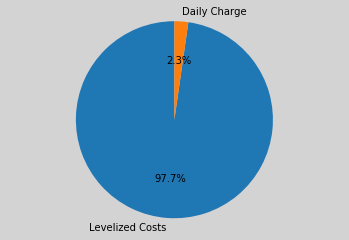

Total roof area of the  building: 599 m²
Total roof area used 471 m²
Percentage: 78.6%
[[190, 140, 180, 1, 51, 16, 0.7, 0.5999999999999999, 0.6499999999999999, 5867.03, 305.975, 0.0, 0.0, 305.975, 1, 'blue', {'Levelized Costs': 5733.978, 'Energy Charge': 0.009999999999763531, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603678653526, 61845.7, 470.731]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      185
azi1       95
azi2      155
tilt0       1
tilt1      11
tilt2      31
gcr0     0.35
gcr1     0.45
gcr2      0.6
Name: 10, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.185]


ERROR:ga_logger:Cost: 5870.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,871 per year


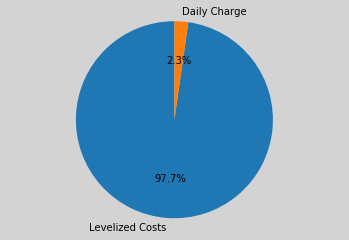

Total roof area of the  building: 599 m²
Total roof area used 510 m²
Percentage: 85.2%
[[185, 95, 155, 1, 11, 31, 0.35, 0.45, 0.5999999999999999, 5870.95, 306.185, 0.0, 0.0, 306.185, 1, 'blue', {'Levelized Costs': 5737.897999999999, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599332569866, 61845.7, 510.308]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      135
azi1      185
azi2      245
tilt0      26
tilt1      41
tilt2      21
gcr0     0.35
gcr1     0.65
gcr2     0.55
Name: 11, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 306.267, 0.0]


ERROR:ga_logger:Cost: 5872.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,873 per year


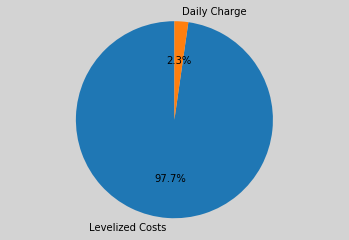

Total roof area of the  building: 599 m²
Total roof area used 471 m²
Percentage: 78.7%
[[135, 185, 245, 26, 41, 21, 0.35, 0.6499999999999999, 0.5499999999999999, 5872.51, 306.267, 0.0, 306.267, 0.0, 1, 'blue', {'Levelized Costs': 5739.456999999999, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601545888414, 61845.7, 471.181]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      240
azi1      140
azi2      180
tilt0       6
tilt1      31
tilt2      46
gcr0     0.45
gcr1      0.8
gcr2     0.55
Name: 12, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.525]


ERROR:ga_logger:Cost: 5877.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,877 per year


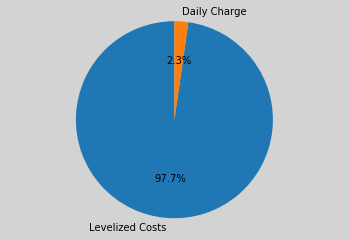

Total roof area of the  building: 599 m²
Total roof area used 557 m²
Percentage: 93.1%
[[240, 140, 180, 6, 31, 46, 0.45, 0.7999999999999998, 0.5499999999999999, 5877.34, 306.525, 0.0, 0.0, 306.525, 1, 'blue', {'Levelized Costs': 5744.289, 'Energy Charge': 0.008999999999900865, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60199279993, 61845.7, 557.318]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      185
azi1      200
azi2       95
tilt0      26
tilt1      16
tilt2      46
gcr0      0.9
gcr1      0.6
gcr2     0.55
Name: 13, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 307.481, 0.0]


ERROR:ga_logger:Cost: 5895.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,895 per year


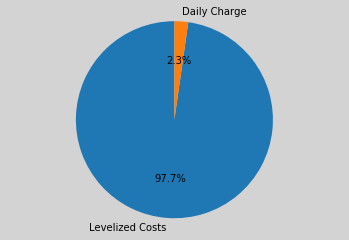

Total roof area of the  building: 599 m²
Total roof area used 512 m²
Percentage: 85.6%
[[185, 200, 95, 26, 16, 46, 0.8999999999999999, 0.5999999999999999, 0.5499999999999999, 5895.25, 307.481, 0.0, 307.481, 0.0, 1, 'blue', {'Levelized Costs': 5762.195, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602540844266, 61845.7, 512.468]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      195
azi1      215
azi2      185
tilt0      41
tilt1      36
tilt2      36
gcr0     0.35
gcr1      0.5
gcr2     0.85
Name: 14, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [140.706, 0.0, 167.233]


ERROR:ga_logger:Cost: 5903.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,904 per year


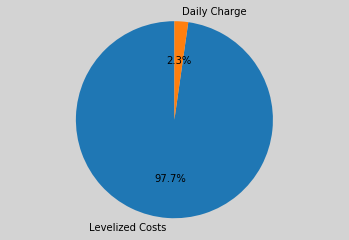

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[195, 215, 185, 41, 36, 36, 0.35, 0.4999999999999999, 0.8499999999999999, 5903.83, 307.93899999999996, 140.706, 0.0, 167.233, 1, 'blue', {'Levelized Costs': 5770.7699999999995, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60175931919, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      195
azi1      170
azi2      150
tilt0      56
tilt1      46
tilt2      56
gcr0     0.55
gcr1      0.5
gcr2     0.35
Name: 15, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 5906.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0026 /kWh
Total Cost of the system: $ 5,907 per year


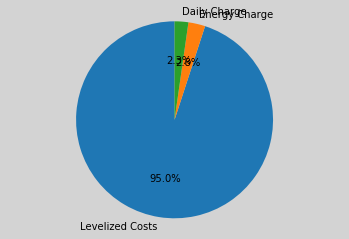

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[195, 170, 150, 56, 46, 56, 0.5499999999999999, 0.4999999999999999, 0.35, 5906.63, 299.381, 0.0, 299.381, 0.0, 1, 'blue', {'Levelized Costs': 5610.393999999999, 'Energy Charge': 163.19400000000041, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60543.318856599944, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      195
azi1      205
azi2      100
tilt0      21
tilt1      16
tilt2      26
gcr0     0.75
gcr1     0.35
gcr2      0.5
Name: 16, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [185.011, 123.228, 0.0]


ERROR:ga_logger:Cost: 5909.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,909 per year


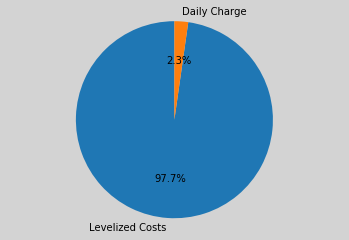

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[195, 205, 100, 21, 16, 26, 0.7499999999999998, 0.35, 0.4999999999999999, 5909.46, 308.239, 185.011, 123.228, 0.0, 1, 'blue', {'Levelized Costs': 5776.398999999999, 'Energy Charge': 0.019000000000119144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60413985377, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0     110
azi1     165
azi2     250
tilt0     21
tilt1     41
tilt2     21
gcr0     0.6
gcr1     0.6
gcr2     0.9
Name: 17, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 308.382, 0.0]


ERROR:ga_logger:Cost: 5912.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,912 per year


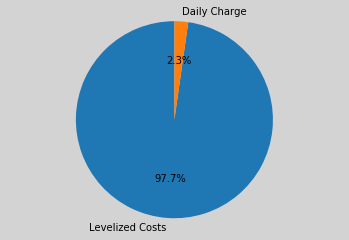

Total roof area of the  building: 599 m²
Total roof area used 514 m²
Percentage: 85.8%
[[110, 165, 250, 21, 41, 21, 0.5999999999999999, 0.5999999999999999, 0.8999999999999999, 5912.13, 308.382, 0.0, 308.382, 0.0, 1, 'blue', {'Levelized Costs': 5779.079, 'Energy Charge': 0.009000000000071395, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600015499935, 61845.7, 513.969]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      195
azi1      195
azi2      120
tilt0      26
tilt1      21
tilt2      46
gcr0     0.85
gcr1     0.35
gcr2      0.8
Name: 18, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [169.085, 139.943, 0.0]


ERROR:ga_logger:Cost: 5924.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 5,924 per year


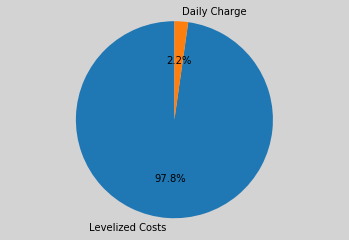

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[195, 195, 120, 26, 21, 46, 0.8499999999999999, 0.35, 0.7999999999999998, 5924.25, 309.028, 169.085, 139.943, 0.0, 1, 'blue', {'Levelized Costs': 5791.204, 'Energy Charge': 0.004000000000246473, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60168925146, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: azi0      120
azi1      155
azi2      230
tilt0       6
tilt1      41
tilt2      31
gcr0     0.55
gcr1      0.5
gcr2     0.75
Name: 19, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 5934.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0031 /kWh
Total Cost of the system: $ 5,935 per year


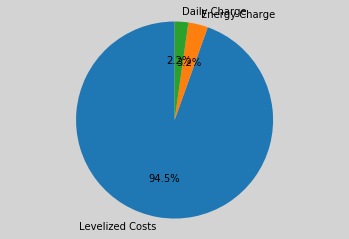

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[120, 155, 230, 6, 41, 31, 0.5499999999999999, 0.4999999999999999, 0.7499999999999998, 5934.83, 299.381, 0.0, 299.381, 0.0, 1, 'blue', {'Levelized Costs': 5610.391999999999, 'Energy Charge': 191.39600000000019, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60318.23100832012, 61845.7, 598.762]]


In [25]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_file=ehub_file,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","DUAL")
pvoptimizer.processGA(ga_proc)